In [144]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import os
import conda
%matplotlib inline
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings('ignore')

In [145]:
service_call_df = pd.read_csv("./sf_service_call.csv")

In [146]:
service_call_df.shape

(4557045, 17)

### EDA

dataset url: https://www.kaggle.com/datasf/san-francisco

data cleaning

In [147]:
#drop the unwanted columns
service_call_df = service_call_df.dropna(subset=['on_scene_timestamp',
                                                 'response_timestamp',
                                                 'zipcode_of_incident',
                                                 'original_priority',
                                                 'watch_date'])
#check no NaNs 
service_call_df.isna().sum()

call_type              0
call_date              0
watch_date             0
received_timestamp     0
on_scene_timestamp     0
response_timestamp     0
dispatch_timestamp     0
entry_timestamp        0
unit_id                0
zipcode_of_incident    0
battalion              0
original_priority      0
priority               0
final_priority         0
unit_type              0
latitude               0
longitude              0
dtype: int64

In [148]:
#keep only the priority to emergency and non-emergency
service_call_df = service_call_df.query("priority == \"2\" or priority == \"3\" ")
service_call_df.shape

(3000702, 17)

In [149]:
service_call_df["priority"] = pd.to_numeric(service_call_df.priority)

In [150]:
service_call_df.head()

,call_type,call_date,watch_date,received_timestamp,on_scene_timestamp,response_timestamp,dispatch_timestamp,entry_timestamp,unit_id,zipcode_of_incident,battalion,original_priority,priority,final_priority,unit_type,latitude,longitude
11,HazMat,2004-09-07,2004-09-07,2004-09-07 12:11:58+00:00,2004-09-07 13:12:14+00:00,2004-09-07 13:01:39+00:00,2004-09-07 12:14:33+00:00,2004-09-07 12:14:01+00:00,HZ1,94124.0,B10,3,3,3,SUPPORT,37.747205,-122.403592
13,Vehicle Fire,2013-10-08,2013-10-07,2013-10-08 04:00:49+00:00,2013-10-08 07:03:44+00:00,2013-10-08 05:11:33+00:00,2013-10-08 05:09:06+00:00,2013-10-08 04:01:00+00:00,UU1,94114.0,B05,3,3,3,SUPPORT,37.754842,-122.446913
19,Citizen Assist / Service Call,2004-10-26,2004-10-25,2004-10-26 05:40:40+00:00,2004-10-26 06:41:44+00:00,2004-10-26 06:16:55+00:00,2004-10-26 05:47:19+00:00,2004-10-26 05:45:18+00:00,UU1,94124.0,B09,3,3,3,SUPPORT,37.722698,-122.397167
25,Structure Fire,2004-09-23,2004-09-22,2004-09-23 03:00:37+00:00,2004-09-23 03:37:40+00:00,2004-09-23 03:18:16+00:00,2004-09-23 03:00:45+00:00,2004-09-23 03:00:40+00:00,AR1,94134.0,B09,3,3,3,INVESTIGATION,37.712255,-122.417104
29,Structure Fire,2004-08-26,2004-08-26,2004-08-26 20:55:50+00:00,2004-08-26 22:10:39+00:00,2004-08-26 21:43:49+00:00,2004-08-26 20:56:25+00:00,2004-08-26 20:56:13+00:00,AR1,94117.0,B05,3,3,3,INVESTIGATION,37.770763,-122.452217


In [151]:
##reduce size of the df, due to runtime
def get_ideal_size(df):
    for i in range(9):
        df = df.iloc[::2]
    return df
#we reduce the size of the df since the runtime is 
#overwhelming for even plotting, since we want labels
service_call_df = get_ideal_size(service_call_df)

In [152]:
service_call_df.shape

(5861, 17)

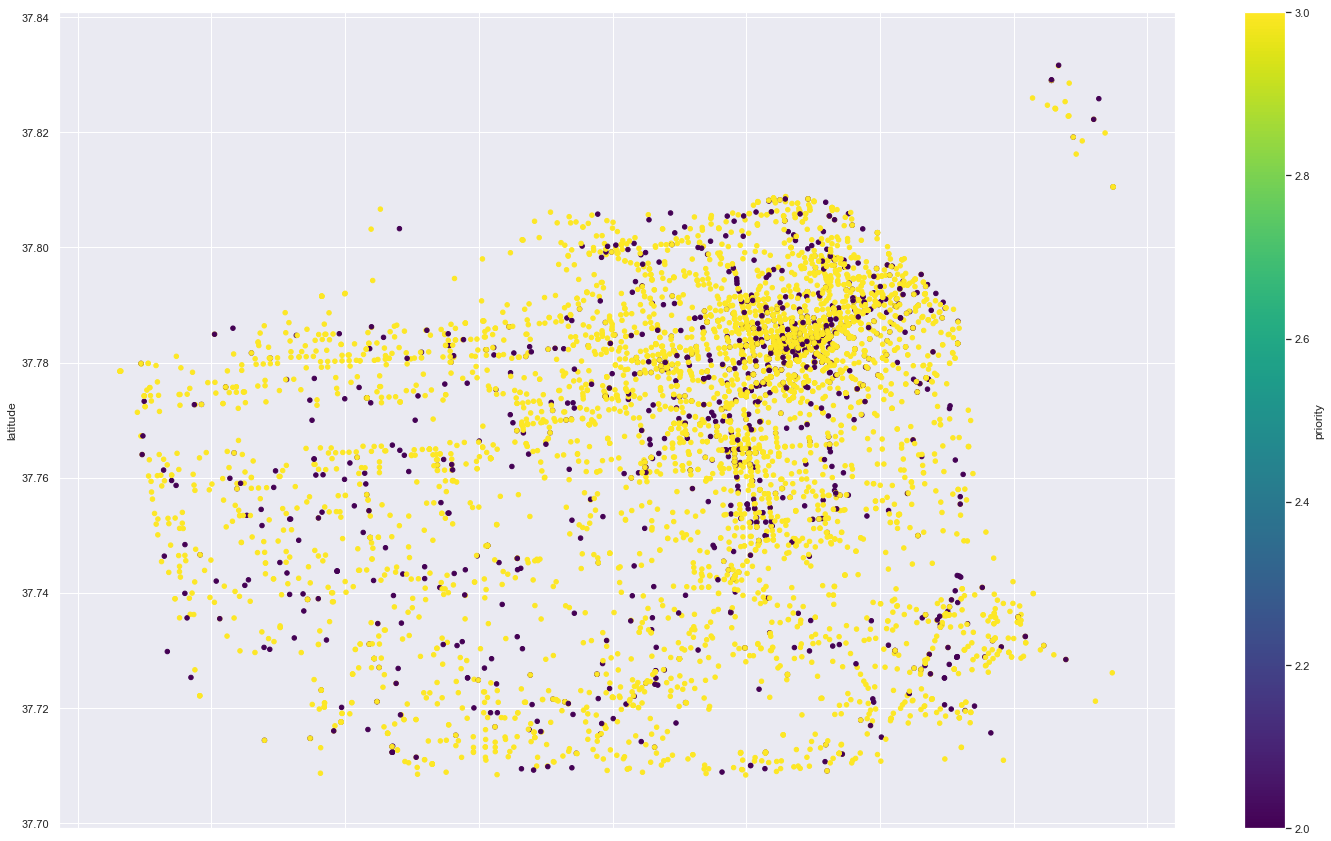

In [153]:
scatter = service_call_df.plot.scatter(x='longitude',
                                       y='latitude' ,
                                       c='priority', 
                                       colormap='viridis',
                                       figsize = (25,15))
fig = scatter.get_figure()
fig.savefig("scatter.pdf")

**We are going to reformat the time stamps within the dataset into date time format**

**snippet only the hours/minutes from the entry call time, which is the time in hours(past) from the 12:00 am the same day of call date, naming the new features into "called_time_passed"**

In [154]:
#get the only time from hours and seconds 
service_call_df["entry_timestamp"] = [i[-15:-6].strip() for i in service_call_df["received_timestamp"]]
#convert into time data(in hours)
service_call_df["called_time_passed"] = [int(i.split(":")[0])+int(i.split(":")[1])/60 for i in service_call_df["entry_timestamp"]]

In [155]:
service_call_df.head()

,call_type,call_date,watch_date,received_timestamp,on_scene_timestamp,response_timestamp,dispatch_timestamp,entry_timestamp,unit_id,zipcode_of_incident,battalion,original_priority,priority,final_priority,unit_type,latitude,longitude,called_time_passed
11,HazMat,2004-09-07,2004-09-07,2004-09-07 12:11:58+00:00,2004-09-07 13:12:14+00:00,2004-09-07 13:01:39+00:00,2004-09-07 12:14:33+00:00,12:11:58,HZ1,94124.0,B10,3,3,3,SUPPORT,37.747205,-122.403592,12.183333
2390,Medical Incident,2014-07-30,2014-07-30,2014-07-30 11:56:43+00:00,2014-07-30 12:04:33+00:00,2014-07-30 12:04:33+00:00,2014-07-30 12:01:01+00:00,11:56:43,BE1,94107.0,B99,3,3,3,SUPPORT,37.781846,-122.392077,11.933333
4011,Water Rescue,2017-02-22,2017-02-22,2017-02-22 11:31:38+00:00,2017-02-22 11:57:27+00:00,2017-02-22 11:51:05+00:00,2017-02-22 11:50:32+00:00,11:31:38,SR1,94132.0,B08,3,3,3,SUPPORT,37.726585,-122.502449,11.516667
5707,Water Rescue,2007-09-04,2007-09-04,2007-09-04 19:47:05+00:00,2007-09-04 20:02:03+00:00,2007-09-04 19:49:55+00:00,2007-09-04 19:48:26+00:00,19:47:05,SR1,94121.0,B07,3,3,3,SUPPORT,37.771342,-122.511054,19.783333
10025,Water Rescue,2013-02-14,2013-02-14,2013-02-14 18:31:17+00:00,2013-02-14 19:11:57+00:00,2013-02-14 18:39:27+00:00,2013-02-14 18:36:21+00:00,18:31:17,FB1,94102.0,B99,3,3,3,SUPPORT,37.782022,-122.413054,18.516667


One of our target of interest is the time lapses between the entry time of the service call and the dispatch or on_scene time, in that we're going to have better sense of how to improve or expedite the service in certain region or unit. However, according to the above statistics, which is the count of missing value within the dataset, <font color = blue> 1056600 </font> count of values are missing from the potential feature "**on_scene_timestamp**". However, since the sample size is large enough, and we decided to drop all the rows with NaNs in col" 'on_scene_timestamp'

In [156]:
service_call_df.unit_type.unique()

array(['SUPPORT', 'CHIEF', 'MEDIC', 'ENGINE', 'PRIVATE', 'INVESTIGATION',
       'TRUCK', 'AIRPORT', 'RESCUE CAPTAIN', 'RESCUE SQUAD'], dtype=object)

In [157]:
service_call_df = service_call_df.drop(columns=['call_date',
                              'watch_date',
                              "received_timestamp", 
                              "on_scene_timestamp" ,
                              "response_timestamp", 
                              "dispatch_timestamp",
                              "entry_timestamp",
                              "unit_id",
                              "original_priority",
                              "final_priority",
                              "battalion"
                              ])
service_call_df.head()

,call_type,zipcode_of_incident,priority,unit_type,latitude,longitude,called_time_passed
11,HazMat,94124.0,3,SUPPORT,37.747205,-122.403592,12.183333
2390,Medical Incident,94107.0,3,SUPPORT,37.781846,-122.392077,11.933333
4011,Water Rescue,94132.0,3,SUPPORT,37.726585,-122.502449,11.516667
5707,Water Rescue,94121.0,3,SUPPORT,37.771342,-122.511054,19.783333
10025,Water Rescue,94102.0,3,SUPPORT,37.782022,-122.413054,18.516667


In [158]:
sum(n < 0 for n in service_call_df.called_time_passed)/service_call_df.shape[0]*100

0.0

Therefore no noise in the newly-cleaned dataset

In [159]:
service_call_df.shape

(5861, 7)

As there are 28 unique zipcodes, 32 unique call types, and 13 unique battalion values in the dataset, the categorical variable is not ordinal or continuous, in that we have a pretty straight forward way of encoding

Since zipcodes is a great representative indicator of the incident area, with more variablity, zipcodes provides a more holistic data coverage. In that we are going to exercise one-hot encoding on feature **"zipcode_of_incident"**

After the shrinkage of datasize, around 20% of the dataset has priority of 2, which is close to the percentage originally

In [160]:
sns.set()

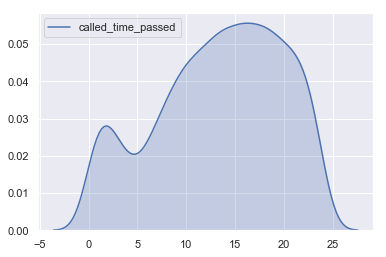

In [161]:
sns.kdeplot(service_call_df.called_time_passed , shade = True)

After the shrinkage of datasize, around 20% of the dataset has priority of 2, which is close to the percentage originally

In [162]:
len(service_call_df[service_call_df["priority"] == 2])/service_call_df.shape[0]*100

19.331172154922367

In [163]:
service_call_df.head()

,call_type,zipcode_of_incident,priority,unit_type,latitude,longitude,called_time_passed
11,HazMat,94124.0,3,SUPPORT,37.747205,-122.403592,12.183333
2390,Medical Incident,94107.0,3,SUPPORT,37.781846,-122.392077,11.933333
4011,Water Rescue,94132.0,3,SUPPORT,37.726585,-122.502449,11.516667
5707,Water Rescue,94121.0,3,SUPPORT,37.771342,-122.511054,19.783333
10025,Water Rescue,94102.0,3,SUPPORT,37.782022,-122.413054,18.516667


In [164]:
###label target of interest of piority
y = np.where(service_call_df['priority'] == 3,1,0)
###one hot encoding for the factors,
service_call_df = pd.get_dummies(service_call_df, columns=['call_type','zipcode_of_incident',
                                                                     'unit_type'])

In [165]:
service_call_df.head()

,priority,latitude,longitude,called_time_passed,call_type_Alarms,call_type_Assist Police,call_type_Citizen Assist / Service Call,call_type_Electrical Hazard,call_type_Elevator / Escalator Rescue,call_type_Explosion,...,unit_type_AIRPORT,unit_type_CHIEF,unit_type_ENGINE,unit_type_INVESTIGATION,unit_type_MEDIC,unit_type_PRIVATE,unit_type_RESCUE CAPTAIN,unit_type_RESCUE SQUAD,unit_type_SUPPORT,unit_type_TRUCK
11,3,37.747205,-122.403592,12.183333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2390,3,37.781846,-122.392077,11.933333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4011,3,37.726585,-122.502449,11.516667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5707,3,37.771342,-122.511054,19.783333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10025,3,37.782022,-122.413054,18.516667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [166]:
service_call_df.shape

(5861, 68)

In [167]:
len(service_call_df[service_call_df["priority"] == 2])/service_call_df.shape[0]*100

19.331172154922367

In [168]:
###get X
X = service_call_df.drop(columns=['priority'])

In [169]:
from sklearn import model_selection
# Reserve 20% for testing
#stratify to ensure the porpotion
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y)
print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4688 observation with 67 features
test data has 1173 observation with 67 features


In [170]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [171]:
y_train

array([1, 0, 1, ..., 1, 1, 1])

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
# Logistic Regression
classifier_logistic = LogisticRegression()
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier(n_neighbors = 5)
# Random Forest
classifier_RF = RandomForestClassifier()
# SVM
classifier_SVC = SVC()

In [173]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [174]:
# Prediction of test data
classifier_logistic.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [175]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.7988064791133845

Note the accuracy of logistic regression is pretty goooood ???

Lets try for more models

In [176]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest', "Support Vector Machine"]
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_SVC]
count = 0
for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print('Model accuracy of %s is: %.5f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.80290
Model accuracy of KNN is: 0.77773
Model accuracy of Random Forest is: 0.75875
Model accuracy of Support Vector Machine is: 0.80503


logistic regression wins,
svm is also pretty good
***

Model evaluations

#### Grid search cross validation to find optimal hyperparameter

In [177]:
from sklearn.model_selection import GridSearchCV
# helper function for printing out grid search results 
def print_grid_search_metrics(gs, parameters):
    print ("Best score: %0.5f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

##### LR: 

In [178]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for regularization term
LR_parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 3, 5, 7, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),LR_parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 3, 5, 7, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [179]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR, LR_parameters)

Best score: 0.80290
Best parameters set:
	C: 1
	penalty: 'l2'


In [180]:
# assign the best model for future modeling and prediction
best_LR_model = Grid_LR.best_estimator_

#### KNN:

In [181]:
# Possible hyperparamter options for KNN
# Choose k
KNN_parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),KNN_parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [182]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_KNN, KNN_parameters)

Best score: 0.78946
Best parameters set:
	n_neighbors: 7


In [183]:
# assign the best model for future modeling and prediction
best_KNN_model = Grid_KNN.best_estimator_

#### RF:

In [184]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
RF_parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),RF_parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 60, 80]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [185]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_RF, RF_parameters)

Best score: 0.77709
Best parameters set:
	n_estimators: 80


In [186]:
# assign the best model for future modeling and prediction
best_RF_model = Grid_RF.best_estimator_

#### SVM:

In [187]:
# Possible hyperparameter options for SVM
# Choose the kernel, gamma, and C
SVM_parameters = {'kernel':('linear', 'rbf'),
              'C':(1,0.25,0.5,0.75),
              'gamma': (1,2,3,'auto'),
              'decision_function_shape':('ovo','ovr'),
              'shrinking':(True,False)}

Grid_SVM = GridSearchCV(SVC(),SVM_parameters, cv=3)
Grid_SVM.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': (1, 0.25, 0.5, 0.75), 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [188]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_SVM, SVM_parameters)

Best score: 0.80674
Best parameters set:
	C: 0.25
	decision_function_shape: 'ovo'
	gamma: 'auto'
	kernel: 'rbf'
	shrinking: True


In [189]:
# assign the best model for future modeling and prediction
best_SVM_model = Grid_SVM.best_estimator_

#### Inferences and results

In [190]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [191]:
# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print([[tn,fn],[fp,tp]]) 
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Non-emergency','Emergency']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.suptitle('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        _ = plt.show()

[[51, 87], [176, 859]]
Random Forest
Accuracy is: 0.776
precision is: 0.830
recall is: 0.908


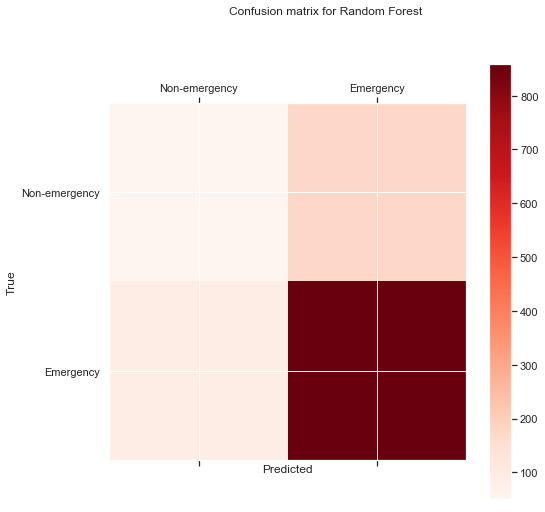

[[11, 20], [216, 926]]
Logistic Regression
Accuracy is: 0.799
precision is: 0.811
recall is: 0.979


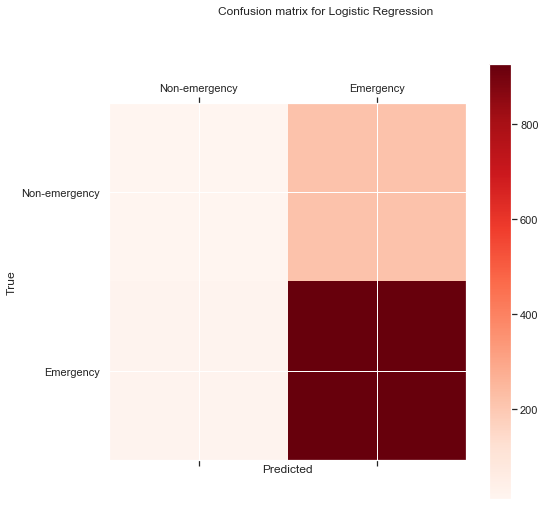

[[0, 0], [227, 946]]
SVM
Accuracy is: 0.806
precision is: 0.806
recall is: 1.000


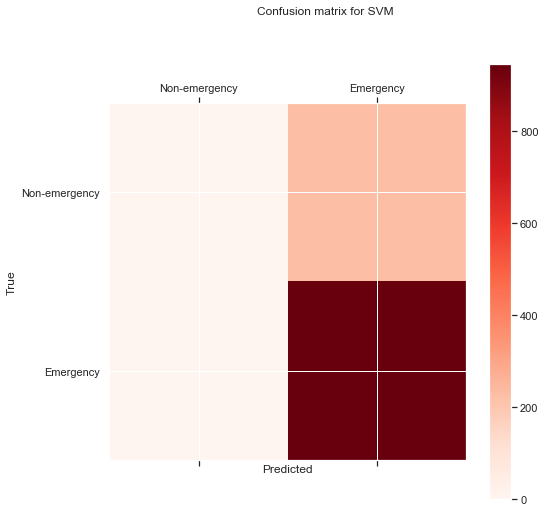

[[28, 54], [199, 892]]
KNN
Accuracy is: 0.784
precision is: 0.818
recall is: 0.943


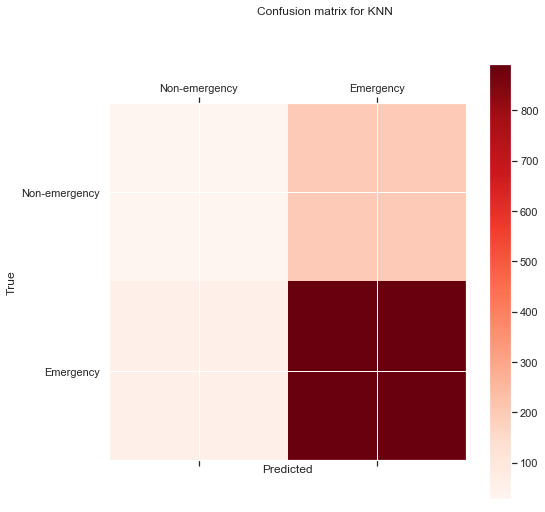

In [192]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("SVM",confusion_matrix(y_test,best_SVM_model.predict(X_test))),
    ("KNN",confusion_matrix(y_test,best_KNN_model.predict(X_test))) 
    
]

draw_confusion_matrices(confusion_matrices)


#### ROC of models:


In [193]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

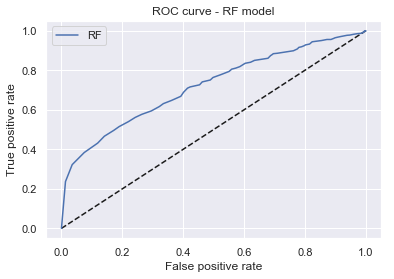

In [194]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [195]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.7196123720557692

In [196]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

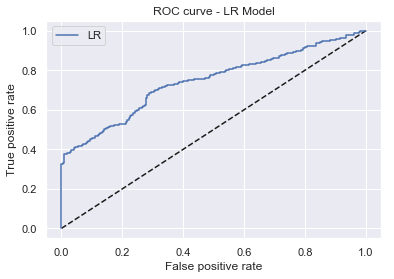

In [197]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [198]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7425654972012926